In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasetCleaner import *
from YUVHandler import *
from pixelFeatures import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [ ]:
videos = ['Vidyo4', 'Dark', 'NetflixDinnerScene', 'KristenAndSara', 'Netflix_DrivingPOV']
qps = ['22', '27', '32','37']

vtm = pd.DataFrame()
for video in videos:
    for qp in qps:

        df_features = pd.read_csv('../datasets/features/dataset_' + video + '_' + qp + '_features.csv')
        height = df_features['frameHeight'].iloc[0]
        width = df_features['frameWidth'].iloc[0]
        df_features = df_features.query('CU_width == 128 & CU_height == 128 & POC > 0 & bottomRight_x < @width & bottomRight_y < @height & bottomRight_x > 0 & bottomRight_y > 0')
        df_features.drop_duplicates(inplace = True)
        df_features.reset_index(drop = True, inplace = True)

        df_target = pd.read_csv('../datasets/target/dataset_' + video + '_' + qp + '_target.csv')

        height = df_target['frameHeight'].iloc[0]
        width = df_target['frameWidth'].iloc[0]

        df_target = df_target.query('CU_width == 128 & CU_height == 128 & POC > 0 & bottomRight_x < @width & bottomRight_y < @height & bottomRight_x > 0 & bottomRight_y > 0')
        df_target = df_target.groupby(by=['videoname','paramQP','frameWidth','frameHeight','CU_width','CU_height','topLeft_x','topLeft_y','bottomRight_x','bottomRight_y','POC','qtdepth','mtdepth','splitType']).min()
        df_target = df_target.reset_index()
        df_target = df_target.drop_duplicates()

        df = pd.merge(df_features, df_target, on=['videoname','paramQP','frameWidth','frameHeight','CU_width','CU_height','topLeft_x','topLeft_y','bottomRight_x','bottomRight_y','POC','qtdepth','mtdepth','splitType'])

        del df_features
        del df_target

        df.drop_duplicates(inplace = True)
        df.reset_index(inplace = True, drop = True)
        df['target'] = df['cost'] > df['RDCost']
        df['target'] = df['target'].apply(lambda x : 1 if x else 0)
        df = df.drop(columns = ['cost', 'RDCost'])
        splits = ['QT_SPLIT', 'BI_HORZ', 'BI_VERT', 'TRI_HORZ', 'TRI_VERT']
        for i in range(len(splits)):
            df['splitType'] = df['splitType'].replace(i+1, splits[i])
        vtm = pd.concat([vtm, df])
vtm.to_csv('../datasets/all/VTM_s0.csv', index = False)

In [ ]:
df = pd.read_csv('../datasets/all/VTM_s0.csv')
splits = ['QT_SPLIT', 'BI_HORZ', 'BI_VERT', 'TRI_HORZ', 'TRI_VERT']

for split in splits:
    aux = df[df['splitType'] == split]
    aux.replace([np.inf, -np.inf], np.nan, inplace=True)
    aux.dropna(inplace = True)
    aux.to_csv('../datasets/' + split + '/s0.csv', index = False)

In [20]:
df = pd.read_csv('../datasets/all/VTM_s0.csv')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace = True)
df = df[df['splitType'] == 'QT_SPLIT']

df['HIVar'] = abs(df['quarter1Var'] - df['quarter2Var']) + abs(df['quarter3Var'] - df['quarter4Var'])
df['HIMean'] = abs(df['quarter1Mean'] - df['quarter2Mean']) + abs(df['quarter3Mean'] - df['quarter4Mean'])
df['HIRatioGrad'] = abs(df['quarter1RatioGrad'] - df['quarter2RatioGrad']) + abs(df['quarter3RatioGrad'] - df['quarter4RatioGrad'])

df['VIVar'] = abs(df['quarter1Var'] - df['quarter3Var']) + abs(df['quarter2Var'] - df['quarter4Var'])
df['VIMean'] = abs(df['quarter1Mean'] - df['quarter3Mean']) + abs(df['quarter2Mean'] - df['quarter4Mean'])
df['VIRatioGrad'] = abs(df['quarter1RatioGrad'] - df['quarter3RatioGrad']) + abs(df['quarter2RatioGrad'] - df['quarter4RatioGrad'])

df['DiffInconsVar'] = abs(df['HIVar'] - df['VIVar'])
df['DiffInconsMean'] = abs(df['HIMean'] - df['VIMean'])
df['DiffInconsRatioGrad'] = abs(df['HIRatioGrad'] - df['VIRatioGrad'])

In [21]:
df

,videoname,frameWidth,frameHeight,paramQP,CU_width,CU_height,topLeft_x,topLeft_y,bottomRight_x,bottomRight_y,...,target,HIVar,HIMean,HIRatioGrad,VIVar,VIMean,VIRatioGrad,DiffInconsVar,DiffInconsMean,DiffInconsRatioGrad
2,Vidyo4,1280,720,22,128,128,1152,128,1279,255,...,1,8.698138,3.548,2.000539,6.695478,4.252,0.045038,2.00266,0.704,1.955501e+00
3,Vidyo4,1280,720,22,128,128,0,0,127,127,...,0,4107.197000,66.812,34.239076,995.987000,13.260,98.719702,3111.21000,53.552,6.448063e+01
5,Vidyo4,1280,720,22,128,128,1024,0,1151,127,...,1,15455.676800,190.419,6.524678,374.719400,6.681,14.871776,15080.95740,183.738,8.347098e+00
13,Vidyo4,1280,720,22,128,128,768,128,895,255,...,1,3350.840400,61.114,0.592535,71717.396400,596.766,1.633631,68366.55600,535.652,1.041096e+00
18,Vidyo4,1280,720,22,128,128,1024,128,1151,255,...,1,41922.610000,574.663,1.069447,17991.210000,254.883,1.069447,23931.40000,319.780,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25512,Netflix_DrivingPOV,1280,720,37,128,128,384,512,511,639,...,0,2632.382000,46.973,1.278162,22176.266000,150.783,1.278162,19543.88400,103.810,2.220446e-16
25515,Netflix_DrivingPOV,1280,720,37,128,128,512,512,639,639,...,0,6819.468000,39.812,0.142546,22574.618000,165.574,0.851677,15755.15000,125.762,7.091314e-01
25518,Netflix_DrivingPOV,1280,720,37,128,128,768,512,895,639,...,1,1599.013000,19.765,5.416820,15242.157000,141.299,79.225160,13643.14400,121.534,7.380834e+01
25521,Netflix_DrivingPOV,1280,720,37,128,128,896,512,1023,639,...,0,722.366000,52.851,8.449774,18693.478000,132.721,8.449774,17971.11200,79.870,1.776357e-15


In [26]:
df = df.drop(columns = ['videoname', 'splitType'])
X = df.drop(columns = 'target')
y = df['target']


forest = RandomForestClassifier(random_state = 0)
scores = cross_val_score(forest, X, y, cv = 5)
scores.mean()

0.5098400984009841

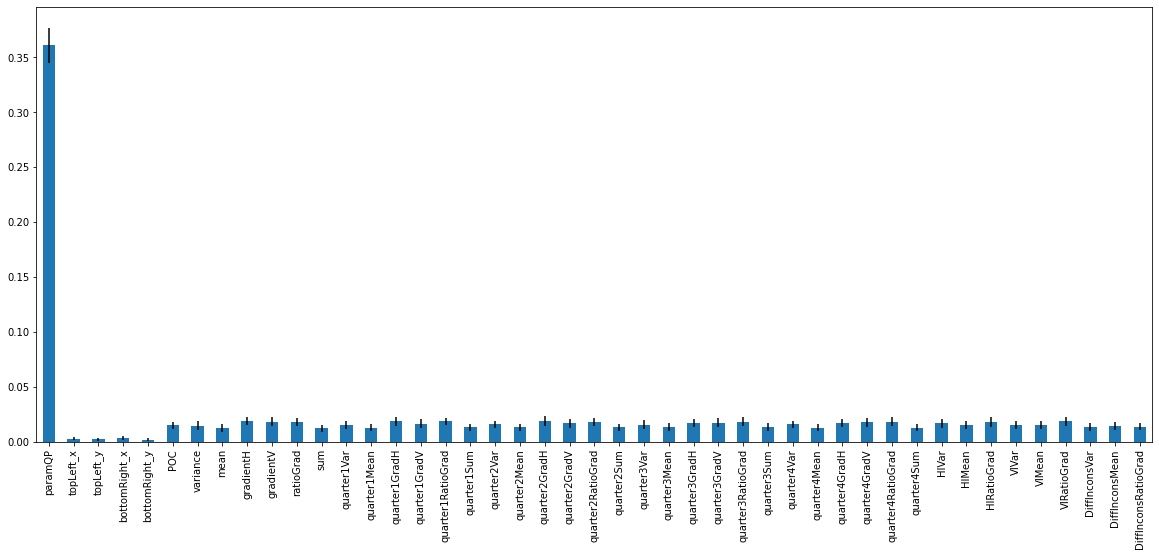

In [28]:
X = df.drop(columns = ['target'])
y = df['target']

constant_filter = VarianceThreshold(threshold = 0.01)
constant_filter.fit(X)
xFilter = constant_filter.transform(X)
columnsFilter = X.columns[constant_filter.get_support()]

x_T = xFilter.T
x_T = pd.DataFrame(x_T)

duplicatedFeatures = x_T.duplicated()
featuresToKeep = [not index for index in duplicatedFeatures]

xUnique = x_T[featuresToKeep].T
columnsUnique = columnsFilter[featuresToKeep]

xUnique.columns = columnsUnique
X = xUnique

forest = RandomForestClassifier(random_state = 0)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
forest_importances = pd.Series(importances, index = X.columns)
forest_importances.plot.bar(yerr = std, figsize = (20,8));

In [32]:
forest = RandomForestClassifier(random_state = 0)
scores = cross_val_score(forest, X, y, cv = 5, n_jobs = 4)
scores.mean()

0.5040590405904058

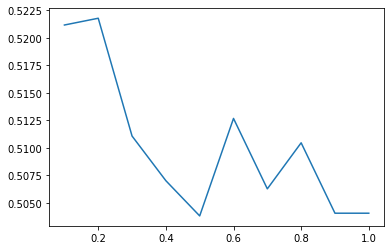

In [59]:
kBest = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
values = []
for k in kBest:

    fs = SelectKBest(score_func = f_classif, k = round((X.shape[1]*k)))
    X_selected = fs.fit_transform(X, y)

    forest = RandomForestClassifier(random_state = 0)
    scores = cross_val_score(forest, X_selected, y, cv = 5, n_jobs = 4)
    values.append(scores.mean())
plt.plot(kBest, values);

In [60]:
fs = SelectKBest(score_func = f_classif, k = round((X.shape[1]*0.2)))
X_selected = fs.fit_transform(X, y)

forest = RandomForestClassifier(random_state = 0)
scores = cross_val_score(forest, X_selected, y, cv = 5, n_jobs = 4)
print('Score: ', scores.mean())

columnsFilter = X.columns[fs.get_support()]
columnsFilter

Score:  0.5217712177121772


Index(['quarter1GradH', 'quarter1RatioGrad', 'quarter2GradH',
       'quarter2RatioGrad', 'quarter3RatioGrad', 'quarter4RatioGrad',
       'HIRatioGrad', 'VIRatioGrad', 'DiffInconsRatioGrad'],
      dtype='object')

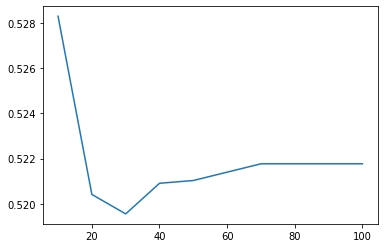

In [39]:
kBest = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
values = []
fs = SelectKBest(score_func = f_classif, k = round((X.shape[1]*0.2)))
X_selected = fs.fit_transform(X, y)
for k in kBest:
    forest = RandomForestClassifier(max_depth = k, random_state = 0)
    scores = cross_val_score(forest, X_selected, y, cv = 5, n_jobs = 4)
    values.append(scores.mean())
plt.plot(kBest, values);

In [52]:
forest = RandomForestClassifier(max_depth = 10, random_state = 0)
scores = cross_val_score(forest, X_selected, y, cv = 5, n_jobs = -1)
scores.mean()

0.5282902829028291

In [53]:
maxFeatures = X.shape[1]
paramGrid = {
      'n_estimators': [i for i in range(1,101,10)],
      'min_samples_split': [i for i in range(5, 51, 5)],
      'min_samples_leaf': [i for i in range(5, 31, 5)],
      'max_depth': [i for i in range(1,51,10)],
      'bootstrap': [0,1],
      'max_samples': [round(0.1*i, 2) for i in range(1, 10)]}
randomGridSearch = RandomizedSearchCV(estimator=RandomForestClassifier(random_state = 0), param_distributions=paramGrid, n_iter=100, scoring=['f1_weighted'], refit = 'f1_weighted', verbose=2, n_jobs=-1)
randomGridSearch.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.7min finished


RandomizedSearchCV(estimator=RandomForestClassifier(random_state=0), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [0, 1],
                                        'max_depth': [1, 11, 21, 31, 41],
                                        'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                        0.6, 0.7, 0.8, 0.9],
                                        'min_samples_leaf': [5, 10, 15, 20, 25,
                                                             30],
                                        'min_samples_split': [5, 10, 15, 20, 25,
                                                              30, 35, 40, 45,
                                                              50],
                                        'n_estimators': [1, 11, 21, 31, 41, 51,
                                                         61, 71, 81, 91]},
                   refit='f1_weighted', scoring=['f1_weighted'], verb

In [54]:
n_estimators = []
min_samples_split = []
min_samples_leaf = []
max_depth = []
bootstrap = []
max_samples = []
accuracy = []

#Separa os valores das combinações testadas na busca aleatória por hiperparâmetro
for combination in randomGridSearch.cv_results_['params']:
    n_estimators.append(combination['n_estimators'])
    min_samples_split.append(combination['min_samples_split'])
    min_samples_leaf.append(combination['min_samples_leaf'])
    max_depth.append(combination['max_depth'])
    bootstrap.append(combination['bootstrap'])
    max_samples.append(combination['max_samples'])
f1_scores              = randomGridSearch.cv_results_['mean_test_f1_weighted']

df = pd.DataFrame()
df['n_estimators'] = n_estimators
df['min_samples_split'] = min_samples_split
df['min_samples_leaf'] = min_samples_leaf
df['max_depth'] = max_depth
df['bootstrap'] = bootstrap
df['max_samples'] = max_samples
df['f1_scores'] = f1_scores

In [55]:
df.sort_values(by='f1_scores')

,n_estimators,min_samples_split,min_samples_leaf,max_depth,bootstrap,max_samples,f1_scores
6,81,30,30,1,1,0.3,0.367194
52,91,35,10,1,1,0.6,0.376339
2,71,40,10,1,1,0.2,0.377161
65,81,15,30,1,0,0.1,0.378711
50,31,45,20,1,1,0.8,0.379822
...,...,...,...,...,...,...,...
78,21,35,10,21,0,0.6,0.507184
15,31,15,25,41,1,0.2,0.508561
73,41,5,5,41,1,0.9,0.509277
28,11,15,5,11,1,0.2,0.510511
